# Arrays, cellular automata, and percolation 

Imports: Make sure these are installed in your conda env, and that the conda env is active in your notebook
+ numpy
+ matplotlib
+ scipy
+ jupyter

For interactive plots:

+ ipykernel

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


%load_ext autoreload
%autoreload 2

# The Abelian sandpile

### Background

We are going to implement the celebrated [Bak-Tang-Wiesenfeld model](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.59.381), also known as the "Abelian sandpile." This cellular automaton describes a lattice in which sand grains are continuously dropped onto random locations at a fixed rate, resulting in the formation of random sandpiles. When the sandpiles grow too high, they topple, resulting in avalanches that distribute grains to all of their neighbors.

If we denote the number of grains at a site $(x, y)$ as $z(x, y)$, a single "topple" event of the BTW model has the following update rule, which triggers only when $z \geq 4$.

$$
z(x, y) \rightarrow z(x, y) - 4
$$

$$
\begin{array}{lr}
    z(x + 1, y) \leftarrow z(x + 1, y) + 1    \\
    z(x - 1, y) \leftarrow z(x - 1, y) + 1    \\
    z(x, y + 1) \leftarrow z(x, y + 1) + 1    \\
    z(x, y - 1) \leftarrow z(x, y - 1) + 1    \\
\end{array}
$$

A topple event thus consists of a single site decreasing in height by four grains, and then distributing these grains to each of its north, south, east, and west neighbors---but not its diagonal neighbors.

After a single topple event, the entire lattice is checked again to see if any other sites now have $z \geq 4$, in which case those sites are toppled, too. If a site located at the boundary of the domain topples, then any grains that would go out of bounds are assumed to be permanently lost from the system. After all sites reach a state where $z \leq 4$, the avalanche has concluded. We then add a sand grain to a random new site, and calculate any new resulting avalanches.

This idealized system has several interesting properties: the continuous addition of grains represents a slow-timescale driving process, which effectively injects energy into the system. The avalances represent fast-timescale response dynamics, and the grains that fall off the edges represent dissipation---they prevent avalanches from continuing forever undriven. Despite its seeming simplicity, the BTK model represents perhaps the earliest widely-studied toy model of "self-organized criticality," a well-known hypothesis in nonequilibrium statistical physics that driven, dissipative systems tend to tune themselves into maximally-critical states (there are always sandpiles on the verge of toppling). The sandpile has been used as a thought experiment describing an incredible array of diverse systems, including: starts and stops in dragging friction, [earthquakes](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/JB094iB11p15635), timings between geyser eruptions, [timings of pulsar glitches](https://arxiv.org/abs/1403.6528), [fluctuations in an ultracold atomic gas](https://www.nature.com/articles/s41586-019-1908-6), [neuronal activity patterns in the brain](https://www.frontiersin.org/articles/10.3389/fnsys.2014.00166/full), [flux pinning](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.67.919), and many other areas.

A simple signature of self-organized-criticality observed in the sandpile model, which also represents an easy readout for experimental data, is the appearance of $1/f$ noise in the system's power spectrum, where $f$ denotes frequency. This distribution implies that avalanche durations have a skewed distribution, where larger events happen less frequently. For an experimental system, this results in "crackling" or brown noise in the detector. In the BTW model, the authors note that a $1/f$ distribution of rare events in the frequency corresponds to a $1/T$ distribution of waiting times between rare events. 

Here we will implement the BTW model, and then test for the appearance of $1/f$ noise.

## To Do:

1. Implement the Abelian Sandpile model and simulate its dynamics. I've included a template of the iterative solution below, although feel free to re-factor if you would prefer to implement the problem a different way. To my knowledge, there are three different ways to implement the Abelian sandpile:
    + The iterative solution involves adding a grain and then repeatedly checking the lattice for piles to topple
    + The recursive depth-first-search solution adds a grain and then traces the avalanche that results from each grain toppled by the initial addition.
    + The breadth-first-search solution adds a grain and then simultaneously tracks the four potential avalanches that result from that single grain.

    My Answer: See my code below,  chose a recursive soluton

2. Using the code included below, show that avalanche durations exhibit a $1/T^\alpha$ distribution, where $\alpha$ is some constant.

    My  answer: I estimated alpha by fitting a line to the Count vs. avalanche duration data, excludng points with low couunts (counts < 10). The fit is overlayed on the plot and looks appropriate with a value of $\alpha = -1.69 \pm 0.12$ and $R^2 = 0.98$.

3. If a single image of the sandpile has size $N$ (the total number of lattice sites), what do you expect to be the worst-case scaling of the runtime of your algorithm? What about the expected scaling of memory usage?

    My Answer: In the worst case, a call to the add an drop function will result in a call to add and drop on every grid point, so a single step of this algorthm is $O(N)$. It is also linear in the number of steps,, so the overal time commplexity is $O(n_{step}N)$. The memory usage is also $O(N n_{step})$ because we store every single state.

4. You may have noticed that the waiting time and avalanche size distribution exhibit anomalous scaling in their tails, as visible as a small second peak near the extreme end of the distribution. What causes this effect?

    My Answer: The finite size oof mmy grid causes this effect. Since avvalanches cannot propogate past the edge of the grid, we artfically introduce a mmaximum avalanche duration. All avalanches that would be longer than this maximum are cut short, resulting in an extra peak in the tail.

5. (Hard, optional) Try [vectorizing](https://realpython.com/numpy-array-programming/) your sandpile implementation, in order to reduce the number of "for" loops used in your implementation. How does vectorization affect the runtime?

**If any experienced student wants to try to implement the Kramer & Marder paper discussed below instead of doing the BTK model, feel free to attempt it. I don't have a solution for it, but I would love to see one.**

In [2]:
class AbelianSandpile:
    """
    An Abelian sandpile model simulation. The sandpile is initialized with a random
    number of grains at each lattice site. Then, a single grain is dropped at a random
    location. The sandpile is then allowed to evolve until it is stable. This process
    is repeated n_step times.

    A single step of the simulation consists of two stages: a random sand grain is 
    dropped onto the lattice at a random location. Then, a set of avalanches occurs
    causing sandgrains to get redistributed to their neighboring locations.
    
    Parameters:
    n (int): The size of the grid
    grid (np.ndarray): The grid of the sandpile
    history (list): A list of the sandpile grids at each timestep
    """

    def __init__(self, n=100, random_state=None):
        self.n = n
        np.random.seed(random_state) # Set the random seed
        self.grid = np.random.choice([0, 1, 2, 3], size=(n, n))
        self.history =[self.grid.copy()] # Why did we need to copy the grid?

    def add_and_drop(self, x, y):
        """
        A recursive function that adds a grain of sand at location (x,Y)
        and topples the pile if the height is >=4. If height is >=4, this function
        calls itself at all adjacent locations. In the base case (height <4), it just
        adds a grain of sand to location x,y.

        Note that the absorbing BCs are implented by just not making any calls to
        (x,y) locations that are outside the grid.

        Parameters:
        x (int): x location to add grain of sand
        y (int): y location to add grain of sand
        """
        self.grid[x,y] +=1
        if self.grid[x,y]>=4:
            self.grid[x,y] -=4 # topple pile
            # Appropriate recursive calls to adjacent cells
            if x > 0:
                self.add_and_drop(x-1,y)
            if x < self.n - 1 :
                self.add_and_drop(x+1,y)
            if y > 0:
                self.add_and_drop(x,y-1)
            if y < self.n - 1 :
                self.add_and_drop(x,y+1)
            return
        else: # base case
            return

    def step(self):
        """
        Perform a single step of the sandpile model. Step corresponds a single sandgrain 
        addition and the consequent toppling it causes. 

        Returns: None
        """
        dropidx = np.random.randint(0,self.n, 2)
        self.add_and_drop(dropidx[0], dropidx[1])


    # we use this decorator for class methods that don't require any of the attributes 
    # stored in self. Notice how we don't pass self to the method
    @staticmethod
    def check_difference(grid1, grid2):
        """Check the total number of different sites between two grids"""
        return np.sum(grid1 != grid2)

    
    def simulate(self, n_step):
        """
        Simulate the sandpile model for n_step steps.

        Parameters:
        n_step (int): number of steps to
        """
        for i in range(0, n_step):
            self.step()
            self.history.append(self.grid.copy())


### Test and use your code

+ You don't need to write any code below, these cells are just to confirm that everything is working and to play with your sandpile implementation
+ If you are working from a local fork of the entire course, then you already have access to the solutions. In this case, make sure to `git pull` to make sure that you are up-to-date (save your work first).
+ If you are working from a single downloaded notebook, or are working in Google Colab, then you will need to manually download the solutions file from the course repository. The lines below will do this for you.

Text(0.5, 1.0, 'Final state')

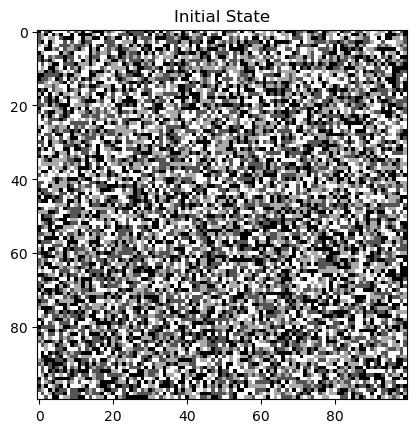

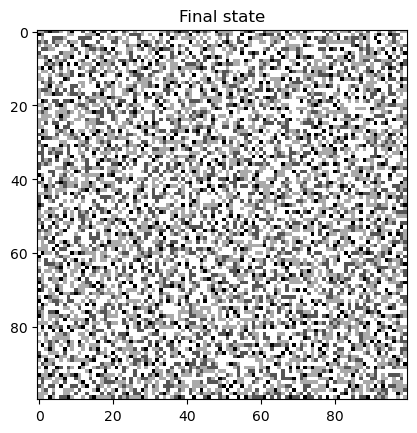

In [54]:
## Import William's solution from answer key
#from solutions.sandpile import AbelianSandpileIterative as AbelianSandpile
# from solutions.sandpile import AbelianSandpileBFS as AbelianSandpile
# from solutions.sandpile import AbelianSandpileDFS as AbelianSandpile


# Run sandpile simulation
model = AbelianSandpile(n=100, random_state=0)

plt.figure()
plt.imshow(model.grid, cmap='gray')
plt.title("Initial State")

model.simulate(10000)
plt.figure()
plt.imshow(model.grid, cmap='gray')
plt.title("Final state")



Text(0.5, 1.0, 'Avalanche activity in most recent timesteps')

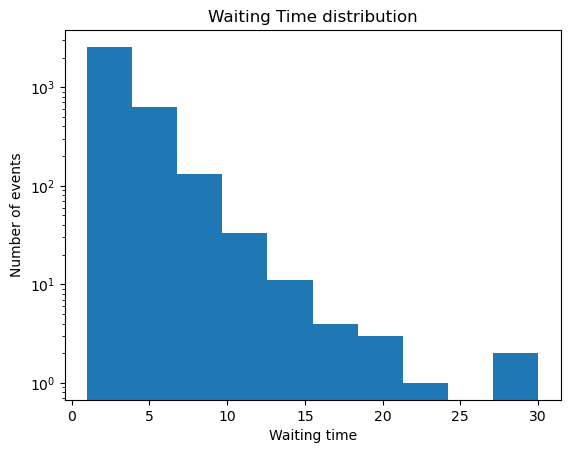

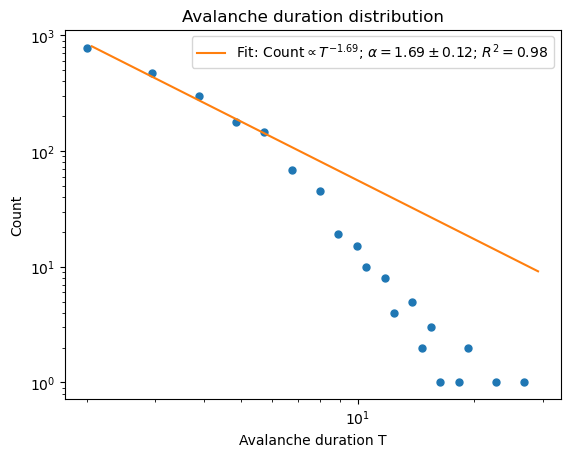

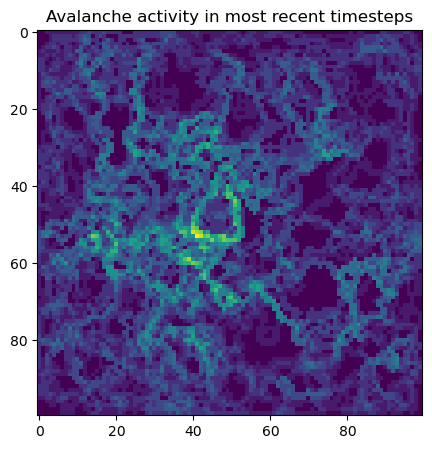

In [55]:
# Compute the pairwise difference between all observed snapshots. This command uses list
# comprehension, a zip generator, and argument unpacking in order to perform this task
# concisely.
all_events =  [model.check_difference(*states) for states in zip(model.history[:-1], model.history[1:])]
# remove transients before the self-organized critical state is reached
all_events = all_events[1000:]
# index each timestep by timepoint
all_events = list(enumerate(all_events))
# remove cases where an avalanche did not occur
all_avalanches = [x for x in all_events if x[1] > 1]
all_avalanche_times = [item[0] for item in all_avalanches]
all_avalanche_sizes = [item[1] for item in all_avalanches]
all_avalanche_durations = [event1 - event0 for event0, event1 in zip(all_avalanche_times[:-1], all_avalanche_times[1:])]


## Waiting time distribution
waiting_times = np.diff(np.array(all_avalanche_times))
plt.figure()
plt.semilogy()
plt.hist(waiting_times)
plt.title('Waiting Time distribution')
plt.xlabel('Waiting time')
plt.ylabel('Number of events')

## Duration distribution
log_bins = np.logspace(np.log10(2), np.log10(np.max(all_avalanche_durations)), 50) # logarithmic bins for histogram
vals, bins = np.histogram(all_avalanche_durations, bins=log_bins)
plt.figure()
plt.loglog(bins[:-1], vals, '.', markersize=10)
plt.title('Avalanche duration distribution')
plt.xlabel('Avalanche duration T')
plt.ylabel('Count')

# Do a fit to get alpha
bin_centers = (bins[:-1] + bins[1:]) / 2
# Define a power-law function to fit the data
def power_law(T, alpha, C):
    return C * T**(-alpha)

# Clean the data a bit by removing low counts
keep_idxs = np.argwhere(vals>10)
from scipy.optimize import curve_fit
# Perform a curve fit
popt, pcov = curve_fit(power_law, bin_centers[keep_idxs].squeeze(), vals[keep_idxs].squeeze())
standarddevparams = np.sqrt(np.diag(pcov))
residuals = vals[keep_idxs] - power_law(bin_centers[keep_idxs], *popt) 
sumressq = np.sum(residuals**2)
squaresum = np.sum((vals[keep_idxs] - np.mean(vals[keep_idxs]))**2)
R2 = 1 - (sumressq/squaresum)


## Plot the fitted power-law
plt.loglog(bin_centers, power_law(bin_centers, *popt), label='Fit: Count' + r'$\propto T^{-%1.2f}$'%popt[0] + '; ' 
           + r'$\alpha = %1.2f \pm %1.2f$'%(popt[0],standarddevparams[0]) + '; ' + r'$R^2 = %.2f$'%R2)
plt.legend()

## Visualize activity of the avalanches
# Make an array storing all pairwise differences between the lattice at successive
# timepoints
all_diffs = np.abs(np.diff(np.array(model.history), axis=0))
all_diffs[all_diffs > 0] = 1
all_diffs = all_diffs[np.sum(all_diffs, axis=(1, 2)) > 1] # Filter to only keep big events
most_recent_events = np.sum(all_diffs[-100:], axis=0)
plt.figure(figsize=(5, 5))
plt.imshow(most_recent_events)
plt.title("Avalanche activity in most recent timesteps")


### Additional information and follow-up

+ Another member of our department, Michael Marder, has a [paper from 1992 in which he and his student Steve Kramer propose a cellular automaton model of river formation.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.68.205) (Figure 2 is gorgeous!). The update rules and structure of implementing this simulation have many simularities to the BTK model, but, unlike the BTK model, there are not any open-source implementations of which I am aware.
+ Among cellular automata, the BTW model is not only unique for its asynchronous nature, but also because it has a "derivative" ruleset in contrast to the "integral"/totalistic ruleset we see in better-known systems like the Game of Life: instead of updating a cell based on the sum of all its neighbors, we update all neighbors based on the state of a cell.
+ The BTK model is called the "Abelian" sandpile because the final stable configuration is invariant to the order of toppling events. For example, instead of toppling the pile to completion after each addition, we could add $M$ several grains at once, and then perform a series of topples selecting unstable sites in any order until a stable configuration is achieved. The final sandpile would be identical to the one we would get if we simulated the pile through $M$ full additions sequentially.


# Percolation

The BTK cellular automaton represents a great example of a simple, toy computational model that exhibits non-trivial properties found in other, much more elaborate problems. It can be considered a [dynamical universality class](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.72.1690), meaning that many problems map onto it, independently of their microscopic details.

Here, we will consider a well-known example of a universality class describing a nonequilibrium phase transition: the directed percolation problem. This problem is usually attributed to [Broadbent & Hammersley in 1957](https://www.cambridge.org/core/journals/mathematical-proceedings-of-the-cambridge-philosophical-society/article/percolation-processes/C00CC4943F48228F8AC8031092FE84EC).

The basic idea is deceptively simple: given a D-dimensional lattice (for our purposes, a 2D grid), we randomly mark sites as "blocked" with probability $p$. The remaining sites are "open" for water to flow. For a given value of $p$, what is the probability that water poured into the top of the lattice will percolate to the bottom row through a chain of connected open sites? This problem is *directed percolation* because it has a preferred direction (water flows from top to bottom). We will assume two open sites are connected if one is north, south, east, or west of the other---but *not* diagonal. This corresponds to [von Neumann neighborhood rules](https://en.wikipedia.org/wiki/Von_Neumann_neighborhood).

A percolation simulation should take a binary array, and return True if it percolates, and False if it does not. There are many ways to implement a percolation algorithm, most of which involve simulating the addition of water to the grid. 
+ *Iterative Solution.* One option would be start with the top row, mark all open sites as "filled," and then pass to the next row and search for open sites connected to filled sites. Some addtional care is required, however, because water can pass through channels within a row until it reaches sites that are not directly below filled sites. One workaround would be to perform multiple iterative passes until the filled lattice stops changing. Another edge case is the case where water needs to pass through an uphill channel in order to make it to the bottom---this can be solved by passing over the lattice first from top to bottom, and then vice versa.
+ *Depth-first search (DFS).* Another simulation option would be a depth-first-search, where we start from each site on the top row and we search for any chain of North/Sout/East/West hops that leads to the other side of the lattice, marking all visited sites as filled with water. This last methods demonstrates the conceptual simularity between directed percolation and solving a maze puzzle; the only difference that the "blocked" sites in a maze are non-random. 

Here we are going to implemented a directed percolation model, and then perform experiments with it in order to determine how the percolation probability depends on the fraction of blocked sites $p$.

## To Do

1. Implement a two dimensional directed percolation model in Python. I've included my code outline below.
    + The iterative solution simulates water pouring into the top row, and then iterate over rows and sites. With this solution, there is some difficulty regarding how to handle the case where water can flow through a channel from right to left, even though we normally iterate from left to right. This can be solved by passing over each row twice. However, there is also a the case where water needs to pass uphill through a channel before it can proceed downhill. This can be solved by passing over the lattice from top to bottom, and then vice versa.
    + Can you think of a faster way of solving this problem? (Hint: we may not have seen recursion in class yet, but it may be helpful). If you want to try implementing your solution, you will need to add an additional private method `_flow_recursive(i, j)` that contains the recursive logic

    My Answer: See the  code below, I chose a recursive solution

2. Perform replicate simulations using the code I've provided below, and create a plot showing how the probability of percolation changes as a function of $p$ (the blockage probability). Beyond seeing the percolation to clogging transition, you'll notice that the variance in the outcome of your simulations behaves unexpectedly. What is going on here? (Hint: If you've studied the Ising model, you've seen something like this before)

    My Answer: The standard deviation of the percolation probability is sharply peaked at the critical clogging probablity $p_c=.407$. At the criitical probability, the cluster size becoomes very large and the outcome of the simulation is very sensitive to randm changes in initial conditions. This makes sense: if the cluster size is nearly as big as the grid size, blockage of a single cluster is blockage of the only cluster, and will cause the lattice not to percolate at all.

3. Theoretically, does the transition point seen in our empirical results align with your intuition? Why does its value differ from $p=0.5$? (Hint: think about sites versus connections between sites).
    My answer: It makes sense based on the fact that we are requiring the percolation to go a speciific direction, top to bottom. It seems like if we allowed percolation to either be left to right or top to bottom, the critical probability couold be 0.5, but since we have restricted it, less blockages are needed to cause a clog.

4. How does the memory usage and runtime of your percolation model implement scale with the lattice size? You can answer this empirically or theoretically.
    
    My answer: The memory scales only with the lattice size. If the total number of points is N, the memry  usage is $O(N)$. The recursive algorithm has run time complexity $O(N^{3/2})$ because each recusrsive call could vissit all $N$ sittes in the worst case, a I make $\sqrt{N}$ calls to the recursive function in the outer for loop.

5. One way to sweep the control parameter $p$ would be to start in a limit where most of the sites are blocked, and then gradually open up individual sites one at a time until the lattice percolates. A video of a simulation where the lattice is gradually opened can be seen [here](https://vimeo.com/747772333). How do the different events in this gradually unblocked percolation simulation relate to the two timescales we saw in the sandpile problem?

    My answer: The unblocking of sites is the slow timescale which corresponds to adding the random grains of sand in the sandpile simulation. The percolation (which happens rappidly as liquid propogates to all coonnected sites before the next randoom site is ubbloocked) is the fast time scale which corresponds to the avalanche in the sandpile simulation.

In [75]:
class PercolationSimulation:
    """
    A simulation of a 2D directed percolation problem. Given a 2D lattice, blocked sites
    are denoted by 0s, and open sites are denoted by 1s. During a simulation, water is
    poured into the top of the grid, and allowed to percolate to the bottom. If water
    fills a lattice site, it is marked with a 2 in the grid. Water only reaches a site
    if it reaches an open site directly above, or to the immediate left or right 
    of an open site.

    I've included the API for my solution below. You can use this as a starting point, 
    or you can re-factor the code to your own style. Your final solution must have a 
    method called percolate that creates a random lattice and runs a percolation 
    simulation and
    1. returns True if the system percolates
    2. stores the original lattice in self.grid
    3. stores the water filled lattice in self.grid_filled

    + For simplicity, use the first dimension of the array as the percolation direction
    + For boundary conditions, assume that any site out of bounds is a 0 (blocked)
    + You should use numpy for this problem, although it is possible to use lists 



    Attributes:
        grid (np.array): the original lattice of blocked (0) and open (1) sites
        grid_filled (np.array): the lattice after water has been poured in
        n (int): number of rows and columns in the lattice
        p (float): probability of a site being blocked in the randomly-sampled lattice
            random_state (int): random seed for the random number generator
        random_state (int): random seed for numpy's random number generator. Used to 
            ensure reproducibility across random simulations. The default value of None
            will use the current state of the random number generator without resetting
            it.
    """

    def __init__(self, n=100, p=0.5, grid=None, random_state=None):
        """
        Initialize a PercolationSimulation object.

        Args:
            n (int): number of rows and columns in the lattice
            p (float): probability of a site being blocked in the randomly-sampled lattice
            random_state (int): random seed for numpy's random number generator. Used to
                ensure reproducibility across random simulations. The default value of None
                will use the current state of the random number generator without resetting
                it.
        """

        self.random_state = random_state # the random seed

        # Initialize a random grid if one is not provided. Otherwise, use the provided
        # grid.
        if grid is None:
            self.n = n
            self.p = p
            self.grid = np.zeros((n, n))
            self._initialize_grid()
        else:
            assert len(np.unique(np.ravel(grid))) <= 2, "Grid must only contain 0s and 1s"
            self.grid = grid.astype(int)
            # override numbers if grid is provided
            self.n = grid.shape[0]
            self.p = 1 - np.mean(grid)

        # The filled grid used in the percolation calculation. Initialize to the original
        # grid. We technically don't need to copy the original grid if we want to save
        # memory, but it makes the code easier to debug if this is a separate variable 
        # from self.grid.
        self.grid_filled = np.copy(self.grid)

    def _initialize_grid(self):
        """
        Sample a random lattice for the percolation simulation. This method should
        write new values to the self.grid and self.grid_filled attributes. Make sure
        to set the random seed inside this method.

        This is a helper function for the percolation algorithm, and so we denote it 
        with an underscore in order to indicate that it is not a public method (it is 
        used internally by the class, but end users should not call it). In other 
        languages like Java, private methods are not accessible outside the class, but
        in Python, they are accessible but external usage is discouraged by convention.

        Private methods are useful for functions that are necessary to support the 
        public methods (here, our percolate() method), but which we expect we might need
        to alter in the future. If we released our code as a library, others might 
        build software that accesses percolate(), and so we should not alter the 
        input/outputs because it's a public method
        """
        self.grid = np.random.choice(np.r_[0,1], size = (self.n, self.n), p = [self.p, 1-self.p])
        self.grid_filled = self.grid.copy()
        

    def _flow_recursive(self, i, j):
        """
        Only used if we opt for a recursive solution.

        The recursive portion of the flow simulation. Notice how grid and grid_filled
        are used to keep track of the global state, even as our recursive calls nest
        deeper and deeper
        """
        
        ####### YOUR CODE HERE  #######################################################
        # Base Cases: Blocked if we are at edge
        if i < 0: 
            return
        if i >=self.n:
            return
        if j < 0: 
            return
        if j >=self.n:
            return
        # Base Case: Skip a bllocked site
        if self.grid[i,j]==0:
            return
        # Final Base Case: Already filled
        if self.grid_filled[i,j]==2:
            return

        self.grid_filled[i, j] = 2
        
        # Otherwise make the recursive call : Fill sites above, below and to left and right
        self._flow_recursive(i + 1, j)
        self._flow_recursive(i, j + 1)
        self._flow_recursive(i, j - 1)
        self._flow_recursive(i - 1, j)

    def _poll_neighbors(self, i, j):
        """
        Check whether there is a filled site adjacent to a site at coordinates i, j in 
        self.grid_filled. Respects boundary conditions.
        """
        if i-1 > 0:
            if self.grid_filled[i-1, j] == 2:
                return True
        if i+1 < self.n:
            if self.grid_filled[i+1, j] == 2:
                return True
        if j-1 > 0:
            if self.grid_filled[i, j-1] == 2:
                return True
        if j+1 < self.n:
            if self.grid_filled[i, j+1] == 2:
                return True
            
        return False

    def _flow(self):
        """
        Run a percolation simulation using recursion

        This method writes to the grid and grid_filled attributes, but it does not
        return anything. In other languages like Java or C, this method would return
        void
        """

        # Try flowing water from each  cell in the topp row
        for j in range(0, self.n):
            self._flow_recursive(0,j)



    def percolate(self):
        """
        Initialize a random lattice and then run a percolation simulation. Report results
        """

        self._flow()

        # Return True if water made it to last row
        return np.any(self.grid_filled[-1] == 2)




### Test and use your code

+ You don't need to write any new code below, these cells are just to confirm that everything is working and to play with the your percolation implementation
+ If you are working from a local fork of the entire course, then you already have access to the solutions. In this case, make sure to `git pull` to make sure that you are up-to-date (save your work first).
+ If you are working from a single downloaded notebook, or are working in Google Colab, then you will need to manually download the solutions file from the course repository. The lines below will do this for you.

True
True
False


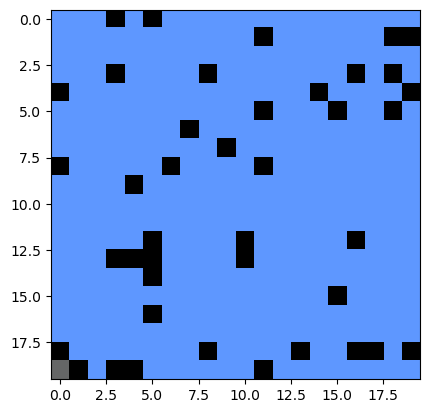

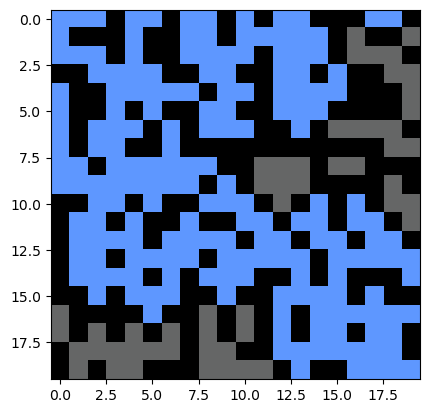

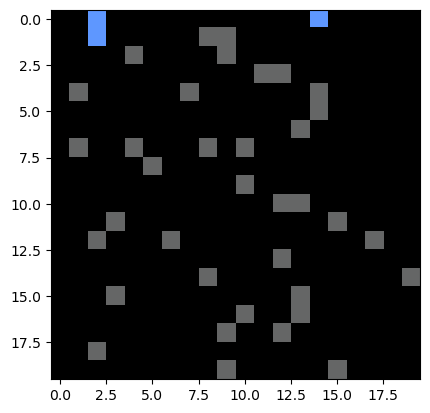

In [79]:
# Import William's solution
# from solutions.percolation import PercolationSimulation
# from solutions.percolation_iterative import PercolationSimulation

from matplotlib.colors import LinearSegmentedColormap
def plot_percolation(mat):
    """
    Plots a percolation matrix, where 0 indicates a blocked site, 1 indicates an empty 
    site, and 2 indicates a filled site
    """
    cvals  = [0, 1, 2]
    colors = [(0, 0, 0), (0.4, 0.4, 0.4), (0.372549, 0.596078, 1)]

    norm = plt.Normalize(min(cvals), max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = LinearSegmentedColormap.from_list("", tuples)
    plt.imshow(mat, cmap=cmap, vmin=0, vmax=2)


model = PercolationSimulation(n=20, random_state=0, p=0.1)
print(model.percolate())
plt.figure()
plot_percolation(model.grid_filled)

model = PercolationSimulation(n=20, random_state=0, p=0.4)
print(model.percolate())
plt.figure()
plot_percolation(model.grid_filled)


model = PercolationSimulation(n=20, random_state=0, p=0.9)
print(model.percolate())
plt.figure()
plot_percolation(model.grid_filled)

Run replicate simulations across replicates with different bond occupation probabilities

The percolation probability represents an effective order parameter for this system, and
so we will attempt to calculate the percolation probability by performing many replicate
simulations at different values of the control parameter $p$.

Running replicate simulations for p = 0.0
Running replicate simulations for p = 0.041666666666666664
Running replicate simulations for p = 0.08333333333333333
Running replicate simulations for p = 0.125
Running replicate simulations for p = 0.16666666666666666
Running replicate simulations for p = 0.20833333333333331
Running replicate simulations for p = 0.25
Running replicate simulations for p = 0.29166666666666663
Running replicate simulations for p = 0.3333333333333333
Running replicate simulations for p = 0.375
Running replicate simulations for p = 0.41666666666666663
Running replicate simulations for p = 0.4583333333333333
Running replicate simulations for p = 0.5
Running replicate simulations for p = 0.5416666666666666
Running replicate simulations for p = 0.5833333333333333
Running replicate simulations for p = 0.625
Running replicate simulations for p = 0.6666666666666666
Running replicate simulations for p = 0.7083333333333333
Running replicate simulations for p = 0.75
Running

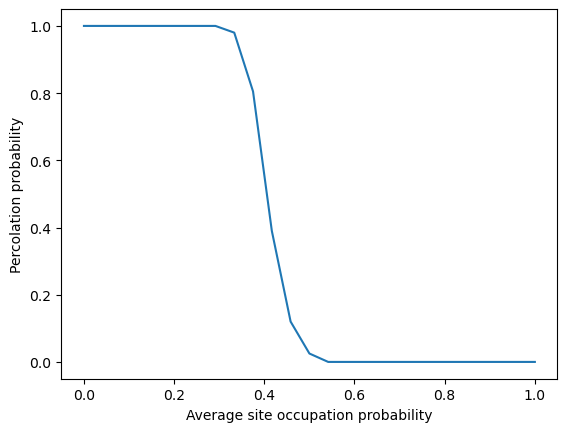

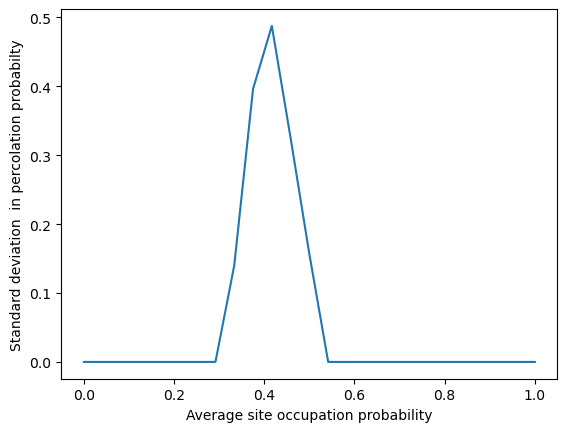

Finished simulation 0
Finished simulation 500
Finished simulation 1000
Finished simulation 1500
Finished simulation 2000
Finished simulation 2500
Finished simulation 3000
Finished simulation 3500
Finished simulation 4000
Finished simulation 4500


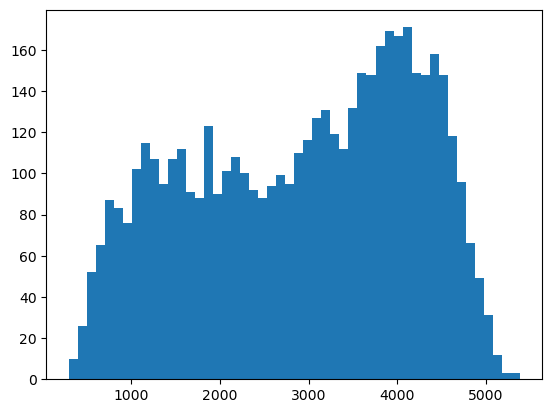

In [81]:

# Import William's solution
#from solutions.percolation import PercolationSimulation

pvals = np.linspace(0, 1, 25) # control parameter for percolation phase transition
n_reps = 200 # number of times to repeat the simulation for each p value

all_percolations = list()
for p in pvals:
    print("Running replicate simulations for p = {}".format(p), flush=True)
    all_replicates = list()
    for i in range(n_reps):
        # Initialize the model
        model = PercolationSimulation(30, p=p)
        all_replicates.append(model.percolate())
    all_percolations.append(all_replicates)

plt.figure()
plt.plot(pvals, np.mean(np.array(all_percolations), axis=1))
plt.xlabel('Average site occupation probability')
plt.ylabel('Percolation probability')

plt.figure()
plt.plot(pvals, np.std(np.array(all_percolations), axis=1))
plt.xlabel('Average site occupation probability')
plt.ylabel('Standard deviation  in percolation probabilty')

plt.show()


## Just from curiousity, plot the distribution of cluster sizes at the percolation threshold
## why does it appear to be bimodal?
all_cluster_sizes = list()
p_c = 0.407259
n_reps = 5000
for i in range(n_reps):
    model = PercolationSimulation(100, p=p_c)
    model.percolate()
    cluster_size = np.sum(model.grid_filled == 2)
    all_cluster_sizes.append(cluster_size)

    if i % 500 == 0:
        print("Finished simulation {}".format(i), flush=True)

all_cluster_sizes = np.array(all_cluster_sizes)

plt.figure()
plt.hist(all_cluster_sizes, 50);


# Follow-up and more information

+ Directed percolation maps onto all sorts of interesting problems in physics and graph theory. There are literal applications of percolation to [flow in porous media](https://iopscience.iop.org/article/10.1088/0305-4470/14/5/012/meta), as well as [electrical conductance](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.26.5293) and [light propagation in disordered materials](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.99.234503). A great example of universality is [recent work](https://www.nature.com/articles/nphys3548) showing similar scaling exponents describe both ecological collapse and pipe turbulence, which both map onto the Directed Percolation universality class. [Here's another recent paper](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007508) that uses percolation theory to understand electrical signalling between neighboring cells in a biofilm. 
+ If you are interested in the mathematical theory of percolation, [Kim Christensen's notes on the subject](https://web.mit.edu/ceder/publications/Percolation.pdf) are extremely clear and interesting.
